### Extremely Randomized Trees ("ExtraTrees")

To solve the overfitting problem by decision trees, we add randomness. Why is randomness good? Randomness is good because then we're not relying on just a few features or samples that happened to be right next to the decision boundary, and then we can be confident in our decision boundary because it works over multiple versions of the data.

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


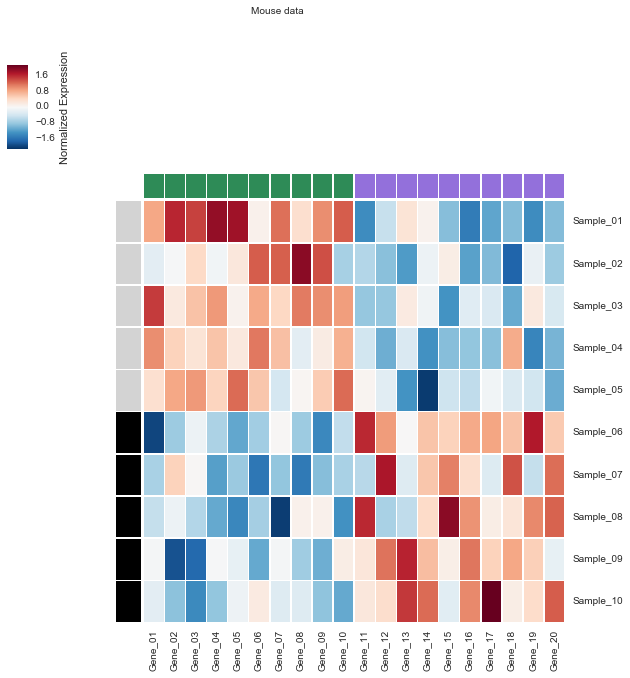

In [1]:
from time import time

import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pandas as pd
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import seaborn as sns
sns.set(context='notebook', style='white')

%matplotlib inline

np.random.seed(2016)

n_samples = 10
n_genes = 20

half_genes = int(n_genes/2)
half_samples = int(n_samples/2)
size = n_samples * n_genes

genes = ['Gene_{}'.format(str(i+1).zfill(2)) for i in range(n_genes)]
samples = ['Sample_{}'.format(str(i+1).zfill(2)) for i in range(n_samples)]

mouse_data = pd.DataFrame(np.random.randn(size).reshape(n_samples, n_genes), index=samples, columns=genes)

# Add biological variance
mouse_data.iloc[:half_samples, :half_genes] += 1
mouse_data.iloc[:half_samples, half_genes:] += -1
mouse_data.iloc[half_samples:, half_genes:] += 1
mouse_data.iloc[half_samples:, :half_genes] += -1

# Z_score within genes
mouse_data = (mouse_data - mouse_data.mean())/mouse_data.std()

# Biological samples
mice = ['Mouse_01', 'Mouse_02']
mouse_groups = pd.Series(dict(zip(mouse_data.index, (['Mouse_01'] * int(n_samples/2)) + (['Mouse_02'] * int(n_samples/2)))), 
                         name="Mouse")
mouse_to_color = dict(zip(['Mouse_01', 'Mouse_02'], ['lightgrey', 'black']))
mouse_colors = [mouse_to_color[mouse_groups[x]] for x in samples]

# Gene colors
gene_colors = (['SeaGreen'] * half_genes) + (['MediumPurple'] * half_genes)
mouse_row_colors = mouse_colors
mouse_col_colors = gene_colors 

g = sns.clustermap(mouse_data, row_colors=mouse_row_colors, col_cluster=False, row_cluster=False, 
                   linewidth=0.5, col_colors=mouse_col_colors,
                   cbar_kws=dict(label='Normalized Expression'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);
g.fig.suptitle('Mouse data')

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


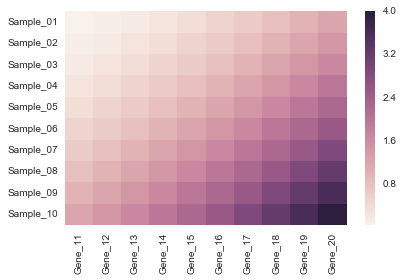

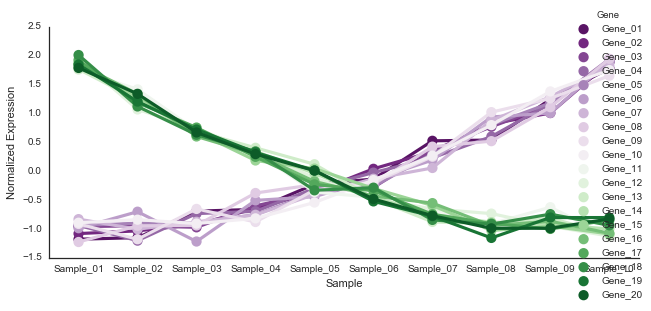

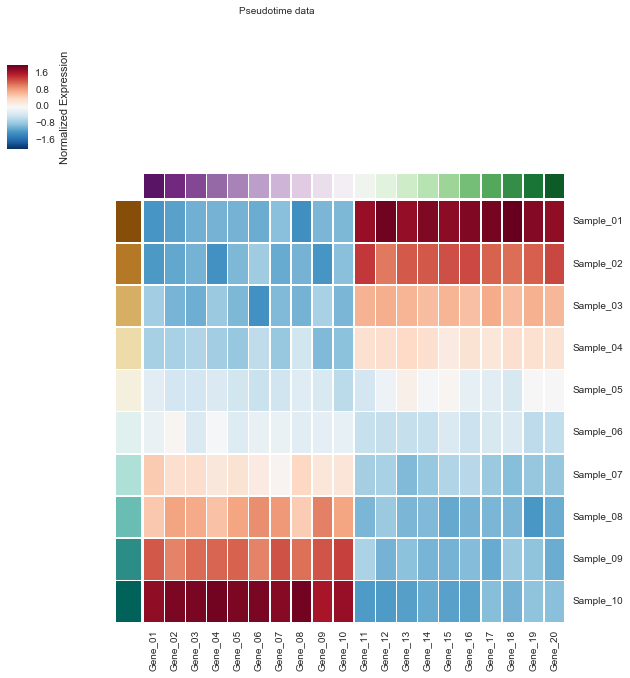

In [15]:
np.random.seed(2016)

n_samples = 10
n_genes = 20

half_genes = int(n_genes/2)
half_samples = int(n_samples/2)
size = n_samples * n_genes

genes = ['Gene_{}'.format(str(i+1).zfill(2)) for i in range(n_genes)]
samples = ['Sample_{}'.format(str(i+1).zfill(2)) for i in range(n_samples)]

pseudotime_data = pd.DataFrame(np.random.randn(size).reshape(n_samples, n_genes), index=samples, columns=genes)

# Make 2d increasing data

increasing_1d = pd.DataFrame(np.ones(n_samples*half_genes).reshape(n_samples, half_genes), 
                                    index=samples, columns=genes[half_genes:])
across_samples = increasing_1d.cumsum()
# sns.heatmap(across_samples)

across_genes = increasing_1d.cumsum(axis=1)
# sns.heatmap(across_genes)

increasing_2d = across_genes + across_samples

increasing_2d = np.square((increasing_2d/half_genes))
sns.heatmap(increasing_2d)

# Add "psueodotime"
pseudotime_data = pd.DataFrame(np.random.randn(size).reshape(n_samples, n_genes), index=samples, columns=genes)
# pseudotime_data.iloc[:, half_genes:] = pseudotime_data.iloc[:, half_genes:] + increasing_2d
# pseudotime_data.iloc[:, :half_genes] = pseudotime_data.iloc[:, :half_genes] + increasing_2d.iloc[::-1, ::-1].values
pseudotime_data.iloc[:, :half_genes] = pseudotime_data.iloc[:, :half_genes].add(np.square(np.arange(n_samples)/2), axis=0)
pseudotime_data.iloc[:, half_genes:] = pseudotime_data.iloc[:, half_genes:].add(np.square(np.arange(n_samples)[::-1]/2), axis=0)

# Normalize genes using z-scores
pseudotime_data = (pseudotime_data - pseudotime_data.mean())/pseudotime_data.std()


pseudotime_sample_groups = ['Early', 'Late']
pseudotime_gene_groups = ['Early', 'Late']
pseudotime_row_colors = sns.color_palette('BrBG', n_colors=n_samples)
pseudotime_col_colors = sns.color_palette("PRGn", n_colors=n_genes)
tidy = pseudotime_data.unstack().reset_index()
tidy = tidy.rename(columns={'level_0': 'Gene', 'level_1': "Sample", 0:'Normalized Expression'})

g = sns.factorplot(data=tidy, hue='Gene', palette=pseudotime_col_colors, x='Sample', 
                   y='Normalized Expression', aspect=2)
# g.map(plt.plot, x='Sample', y='Normalized Expression')


g = sns.clustermap(pseudotime_data, row_colors=pseudotime_row_colors, col_cluster=False, row_cluster=False, 
                   linewidth=0.5, col_colors=pseudotime_col_colors,
                   cbar_kws=dict(label='Normalized Expression'))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);
g.fig.suptitle('Pseudotime data')

In [16]:
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

In [17]:
# Convert mouse color labels to numbers for sckit-learn
mouse_target = [0 if x == 'black' else 1 for x in mouse_colors]
mouse_target

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


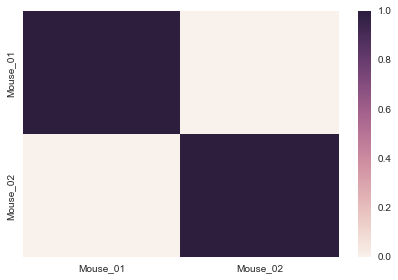

In [18]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(mouse_data, mouse_target, test_size=.4)
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

classifier.predict(X_test)

y_test


confusion = pd.DataFrame(confusion_matrix(y_test, classifier.predict(X_test)), index=mice, columns=mice)
confusion = confusion/confusion.sum()
sns.heatmap(confusion)

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


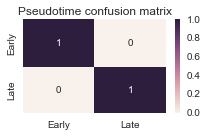

In [28]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(pseudotime_data, mouse_target, test_size=.4)
classifier = SVC(kernel='linear', random_state=2016)
classifier.fit(X_train, y_train)

classifier.predict(X_test)

confusion = pd.DataFrame(confusion_matrix(y_test, classifier.predict(X_test)), 
                         index=pseudotime_sample_groups, columns=pseudotime_sample_groups)
confusion = confusion/confusion.sum()

fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(confusion, annot=True)
ax.set(title='Pseudotime confusion matrix')

In [29]:
from sklearn.decomposition import PCA, FastICA

In [30]:
X = pseudotime_data.values
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

whole_expression_space = np.c_[xx.ravel(), yy.ravel()]
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


ValueError: X.shape[1] = 2 should be equal to 20, the number of features at training time

In [32]:
pseudotime_data.values

array([[-1.18334826, -1.0855335 , -0.96571523, -0.94492614, -0.943452  ,
        -0.99243466, -0.83530663, -1.23163534, -0.91870897, -0.8974452 ,
         1.75215926,  1.94989824,  1.76130972,  1.86858698,  1.79813632,
         1.85162691,  1.91767843,  2.00742844,  1.84179814,  1.7841612 ],
       [-1.15574493, -1.03894218, -0.95102446, -1.20795657, -0.90641307,
        -0.70674653, -1.01029606, -0.95086268, -1.1834891 , -0.84495602,
         1.41254984,  1.06483635,  1.23390129,  1.25094342,  1.28733981,
         1.33185   ,  1.18247756,  1.11667193,  1.20158312,  1.33493554],
       [-0.69725167, -0.92746399, -0.97728389, -0.73936339, -0.90199647,
        -1.2229609 , -0.88190353, -0.9449128 , -0.65856426, -0.9123891 ,
         0.69967777,  0.73243869,  0.685082  ,  0.62039726,  0.67481533,
         0.59666874,  0.75070827,  0.62667324,  0.71713671,  0.66638234],
       [-0.66613872, -0.65104796, -0.60597344, -0.70012776, -0.75741971,
        -0.51077104, -0.76220103, -0.38284615, -

NameError: name 'Z' is not defined

/Users/olga/anaconda3/envs/single-cell-bioinformatics-v3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


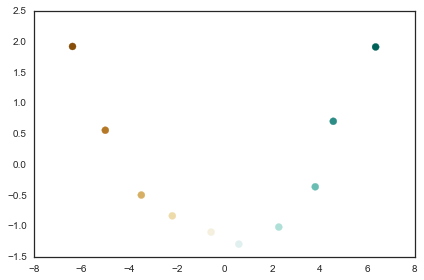

In [27]:
smusher = PCA(n_components=2)

smushed = smusher.fit_transform(pseudotime_data)

fig, ax = plt.subplots()

ax.scatter(smushed[:, 0], smushed[:, 1], color=pseudotime_row_colors, s=50)
cs = plt.contourf(xx, yy, Z, cmap='BRGn')
